# AirBnB : Part 2 : Features selection ALL CITIES

In [44]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.feature_selection import SelectKBest,VarianceThreshold
from sklearn.feature_selection import chi2,f_classif
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.grid_search import GridSearchCV

from xgboost import XGBClassifier

from utils import rstr,distance

import pickle

airBColor= '#ff5a5f'
airBColor2= '#008489'

In [45]:
df = pd.read_csv('../../data/all_cities/listing_cleansed_fillna.csv')
print df.host_id.isnull().sum()
df.drop('listings_per_host',axis=1,inplace=True)

0


### Add distance to city center

In [46]:
df_city_center = pd.read_csv('../../data/all_cities/distance_to_center.csv')

In [47]:
city_center_dict =df_city_center.to_dict(orient='index')
df['coordinate']=list(zip(df.latitude, df.longitude))

In [48]:
coord_brandenburg_tor = (52.516849,13.377661)

def distance_highlight(center_coord,x):
    return distance(center_coord,x)

for city in city_center_dict.values():
    center_coord = (city['latitude'],city['longitude'])
    city_center_name = ''.join(['distance_to_center_',city['city']])
    df[city_center_name] = df['coordinate'].apply(lambda x : distance_highlight(center_coord,x))
    
df.drop('coordinate',axis=1,inplace=True) 

### Filter on numeric features

In [49]:
cols_num = df.select_dtypes(['number']).columns.tolist()
cols_not_num = set(df.columns.tolist())-set(cols_num)
cols_not_num

{'city'}

In [50]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_sample = df.select_dtypes(include=numerics)

### Remove listing with no reviews

In [51]:
df = df[df_sample.availability_90>0]

In [52]:
df.shape

(56879, 411)

### Replace abnormal values and missing data

In [54]:
df.loc[df['maximum_nights'] > 1125, 'maximum_nights'] = 1125


In [55]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent


### Add target label

In [56]:
TARGET = 'multihost'

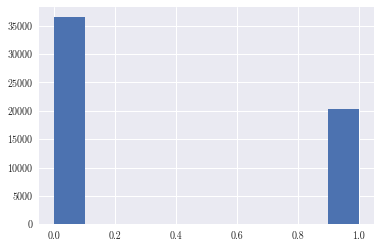

In [57]:
df.multihost.hist()

### Split Features and Target 

In [58]:
print df.shape
df_sample  = df_sample.sample(frac=.2).copy()
print df_sample.shape
print df.shape

(56879, 411)
(11376, 410)
(56879, 411)


In [59]:
y = df_sample[TARGET]
X = df_sample.drop([TARGET,'listing_id','host_id'],axis=1)

### Drop zero variance and Scale X 

In [60]:
print X.shape
X = X.loc[:, X.std()>0]
print X.shape

(11376, 407)
(11376, 384)


In [61]:
X = X.apply(lambda x: MinMaxScaler().fit_transform(x),axis=0)

/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your 

In [62]:
print X.shape,y.shape

(11376, 384) (11376,)


### Correlation matrix

### Selection using RandomizedLogisticRegression_selector

In [63]:
def RandomizedLogisticRegression_selector(X,y):
    clf = RandomizedLogisticRegression()
    columns = X.columns
    clf.fit(X,y)
    idx =  clf.get_support(indices=True)
    return X[X.columns[idx]].columns.tolist()

In [64]:
features_RLR = RandomizedLogisticRegression_selector(X,y)

In [65]:
features_RLR
pickle.dump(features_RLR, open('best_features/features_RLR.p', 'wb'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f427b51ad90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4279ba2450>]], dtype=object)

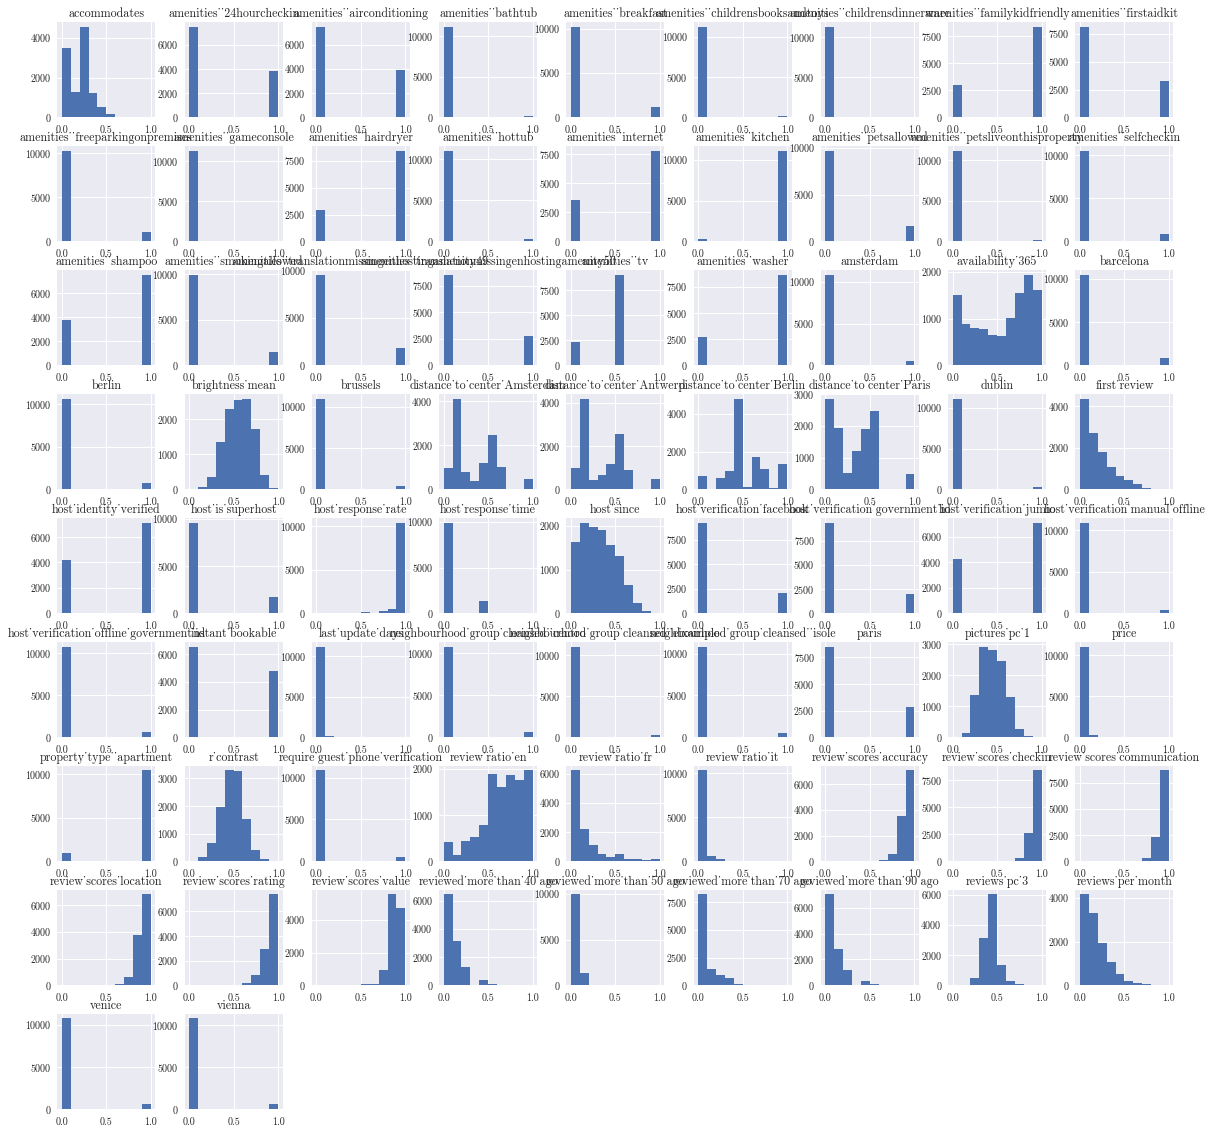

In [66]:
X[features_RLR].hist(figsize=(20,20))

In [67]:
not_binary_values = [col for col in X[features_RLR] if 
               not X[col].dropna().value_counts().index.isin([0,1]).all()]
not_binary_values 

['accommodates',
 'amenities__tv',
 'availability_365',
 'first_review',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'last_update_days',
 'price',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'reviewed_more_than_40_ago',
 'reviewed_more_than_50_ago',
 'reviewed_more_than_70_ago',
 'reviewed_more_than_90_ago',
 'review_ratio_en',
 'review_ratio_fr',
 'review_ratio_it',
 'reviews_pc_3',
 'pictures_pc_1',
 'r_contrast',
 'brightness_mean',
 'distance_to_center_Amsterdam',
 'distance_to_center_Antwerp',
 'distance_to_center_Berlin',
 'distance_to_center_Paris']

In [85]:
features_to_log =['accommodates',
  'availability_365',
  'first_review',
  'host_since',
  'latitude',
  'price',
  'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_rating',
 'review_scores_value',
  'reviews_per_month',
 'reviewed_more_than_40_ago',

 'reviewed_more_than_70_ago',
  'host_response_rate',
 'amenities__tv',
 'host_response_time',
 'last_update_days',
]

### Selection using KbestSelection

In [69]:
def SelectKBest_features(X,y,method, n_features):
    selector = SelectKBest(method, k=n_features)
    selector.fit(X, y)
    # Get idxs of columns to keep
    idx =  selector.get_support(indices=True)
    return X[X.columns[idx]].columns.tolist()

In [70]:
features_Kbest_chi2 = SelectKBest_features(X,y,chi2,20)
features_Kbest_fclass = SelectKBest_features(X,y,f_classif,20)

In [71]:
features_Kbest_chi2
pickle.dump(features_Kbest_chi2, open('best_features/features_Kbest_chi2.p', 'wb'))
pickle.dump(features_Kbest_fclass, open('best_features/features_Kbest_fclass.p', 'wb'))

In [72]:
features_Kbest_fclass

['accommodates',
 'amenities__airconditioning',
 'amenities__translationmissingenhostingamenity50',
 'availability_365',
 'host_response_time',
 'host_since',
 'instant_bookable',
 'latitude',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_rating',
 'paris',
 'reviews_pc_3',
 'brightness_mean',
 'distance_to_center_Amsterdam',
 'distance_to_center_Antwerp',
 'distance_to_center_Berlin',
 'distance_to_center_Brussels',
 'distance_to_center_London',
 'distance_to_center_Paris']

### Selection using Xgboost

In [73]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1,scoring="recall")
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_

In [74]:
params = {
    'max_depth':12,
    'min_child_weight':2,
    'learning_rate' :0.1,
    'gamma':0.0,
    'n_estimators':200
}

print params

clf = XGBClassifier(**params)


best_clf = clf.fit(X,y)
print(best_clf)

{'n_estimators': 200, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 2}
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=2, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


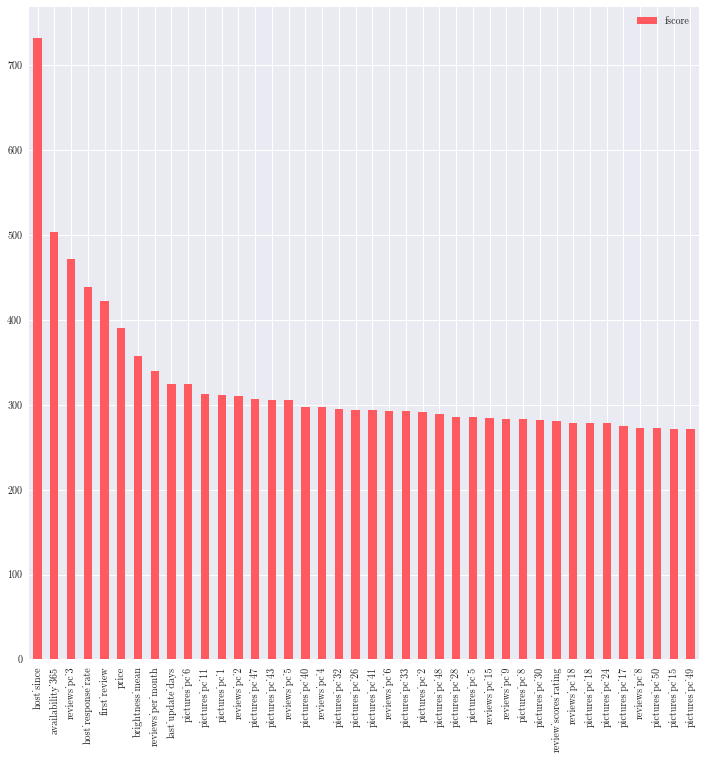

In [75]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")
features_weights.columns = ['fscore']

features_weights.sort_values(by='fscore',ascending=False).head(40).plot(kind='bar',title='',color=airBColor,figsize=(12,12))

In [76]:
XGB_features = features_weights.sort_values(by='fscore',ascending=False).head(20).index.tolist()
pickle.dump(XGB_features,open('XGB_features.p','wb'))

### Plot best  5 features from Kbest fclass

In [77]:
df_scatter_plot = X[XGB_features[:5]]
df_scatter_plot['is_multihost']=y

/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [78]:
df_scatter_plot.columns = [f.replace("amenities__translationmissingenhosting","") for f in df_scatter_plot.columns]

In [79]:
df_scatter_plot.columns

Index([u'host_since', u'availability_365', u'reviews_pc_3',
       u'host_response_rate', u'first_review', u'is_multihost'],
      dtype='object')

In [80]:
good_features = df_scatter_plot.columns.tolist()

good_features.remove('is_multihost')

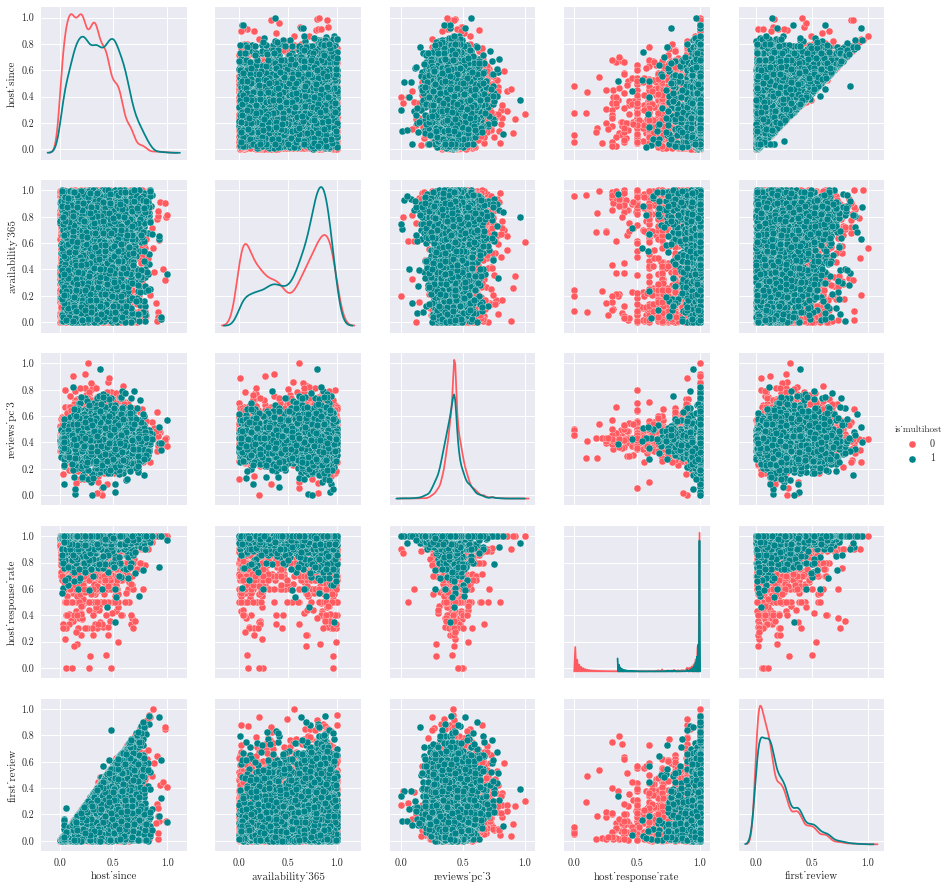

In [81]:
sns.set_style("darkgrid", { 'font.family': ['cmr10']})
sns.pairplot(df_scatter_plot, hue="is_multihost",diag_kind='kde',vars=good_features,palette={0:airBColor,1:airBColor2})


### Create a list of the overall best features

In [82]:
BEST_FEATURES = list(set(features_RLR+XGB_features+features_Kbest_chi2+features_Kbest_fclass+['latitude','longitude']))
len(BEST_FEATURES)

88

In [83]:
BEST_FEATURES.sort()
pickle.dump(BEST_FEATURES,open('best_features/best_features.p','wb'))

In [86]:
df_dataset_for_modeling = pd.concat([df[TARGET],df[BEST_FEATURES],df['city']],axis=1)
df_dataset_for_modeling[features_to_log]= np.log(df_dataset_for_modeling[features_to_log]+1)

In [87]:
df_dataset_for_modeling.to_csv('../../data/all_cities/dataset_for_modeling.csv',index=None)